<a href="https://colab.research.google.com/github/muhammmad-al/decentralized-ai-content-recommender/blob/main/reddit_federated_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content
Cloning into 'decentralized-ai-content-recommender'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 118 (delta 43), reused 57 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (118/118), 11.26 MiB | 19.34 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/decentralized-ai-content-recommender
Node 1 (NA) Dataset Overview:
Total samples: 6694

Category distribution:
category
music    2399
web3     2180
ai       2115
Name: count, dtype: int64
Node 2 (EU) Dataset Overview:
Total samples: 4481

Category distribution:
category
web3     1655
ai       1596
music    1230
Name: count, dtype: int64
Node 3 (ASIA) Dataset Overview:
Total samples: 3825

Category distribution:
category
music    1371
ai       1289
web3     1165
Name: count, dtype: int64

Federated Round 1/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7123 - loss: 2.

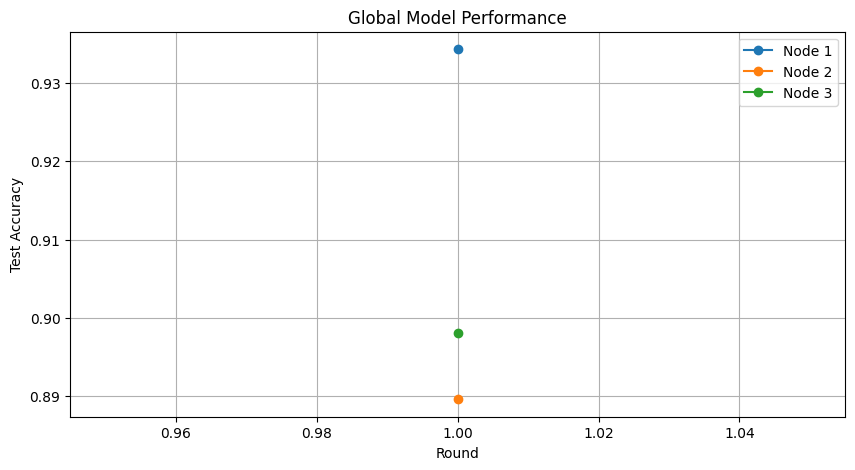


Federated Round 2/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9175 - loss: 0.4994 - val_accuracy: 0.9617 - val_loss: 0.3881
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9478 - loss: 0.3503 - val_accuracy: 0.9645 - val_loss: 0.2820
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9500 - loss: 0.2828 - val_accuracy: 0.9599 - val_loss: 0.2523
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9592 - loss: 0.2452 - val_accuracy: 0.9655 - val_loss: 0.2198
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9577 - loss: 0.2230 - val_accuracy: 0.9627 - val_loss: 0.1957

Training Node 2
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9058 - loss: 0.5455 - val_accuracy: 0.9484 - val_loss: 0.4385
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9418 - loss: 0.3996 - val_accuracy: 0.9582 - val_loss: 0.3527
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

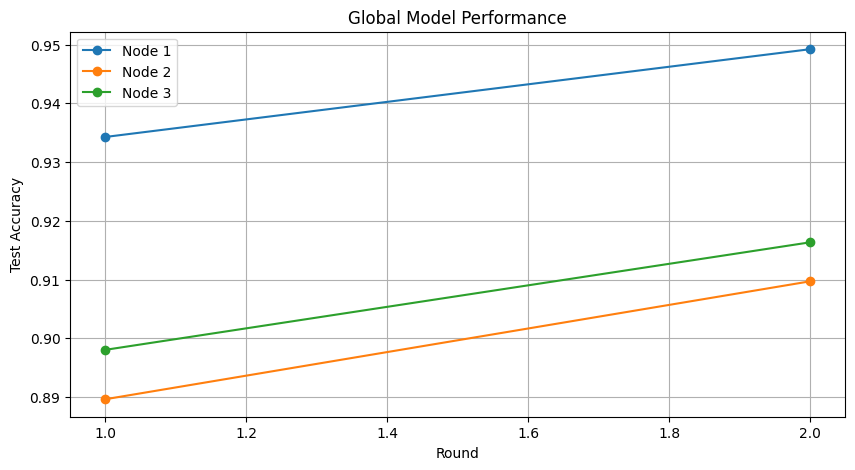


Federated Round 3/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9384 - loss: 0.2840 - val_accuracy: 0.9570 - val_loss: 0.2333
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9448 - loss: 0.2431 - val_accuracy: 0.9617 - val_loss: 0.1932
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9566 - loss: 0.2162 - val_accuracy: 0.9570 - val_loss: 0.1999
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9554 - loss: 0.1962 - val_accuracy: 0.9608 - val_loss: 0.1804
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9599 - loss: 0.1820 - val_accuracy: 0.9561 - val_loss: 0.1825

Training Node 2
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9051 - loss: 0.3390 - val_accuracy: 0.9540 - val_loss: 0.2451
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9595 - loss: 0.2379 - val_accuracy: 0.9247 - val_loss: 0.2686
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

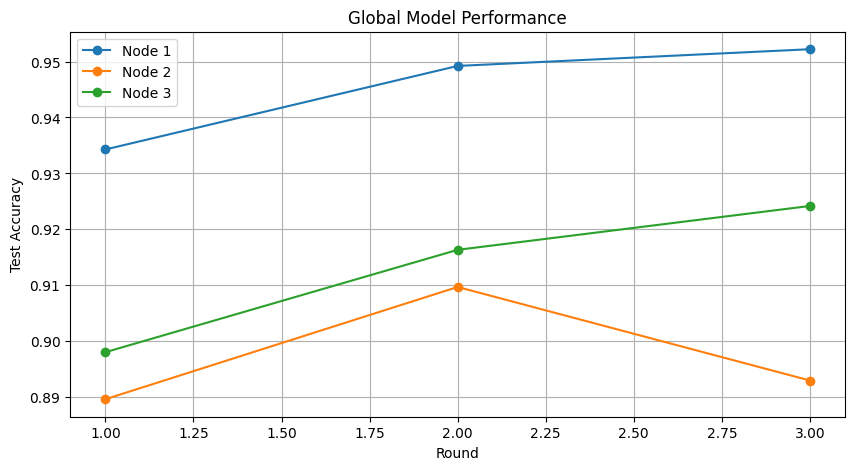


Federated Round 4/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9409 - loss: 0.2451 - val_accuracy: 0.9533 - val_loss: 0.1953
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9517 - loss: 0.2078 - val_accuracy: 0.9627 - val_loss: 0.1770
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9558 - loss: 0.1855 - val_accuracy: 0.9570 - val_loss: 0.1831
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9515 - loss: 0.1917 - val_accuracy: 0.9570 - val_loss: 0.1732
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9594 - loss: 0.1740 - val_accuracy: 0.9589 - val_loss: 0.1712

Training Node 2
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9133 - loss: 0.2982 - val_accuracy: 0.9498 - val_loss: 0.2151
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9505 - loss: 0.2138 - val_accuracy: 0.9512 - val_loss: 0.2022
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

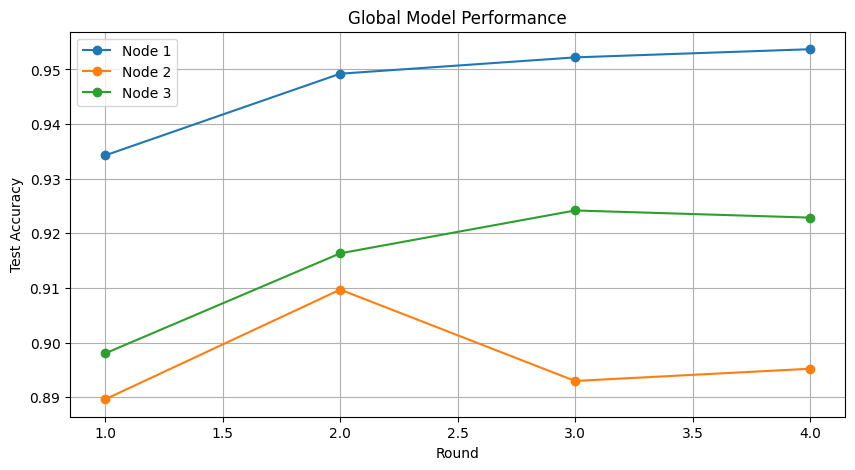


Federated Round 5/5

Training Node 1
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9436 - loss: 0.2059 - val_accuracy: 0.9636 - val_loss: 0.1606
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9561 - loss: 0.1773 - val_accuracy: 0.9542 - val_loss: 0.1688
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9470 - loss: 0.1928 - val_accuracy: 0.9449 - val_loss: 0.1915
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9572 - loss: 0.1727 - val_accuracy: 0.9570 - val_loss: 0.1593

Training Node 2
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9140 - loss: 0.2647 - val_accuracy: 0.9498 - val_loss: 0.1892
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9554 - loss: 0.1838 - val_accuracy: 0.9289 - val_loss: 0.2101
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9541 - loss: 0.1960 - val_accuracy: 0.9540 - val_loss: 0.1949
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0

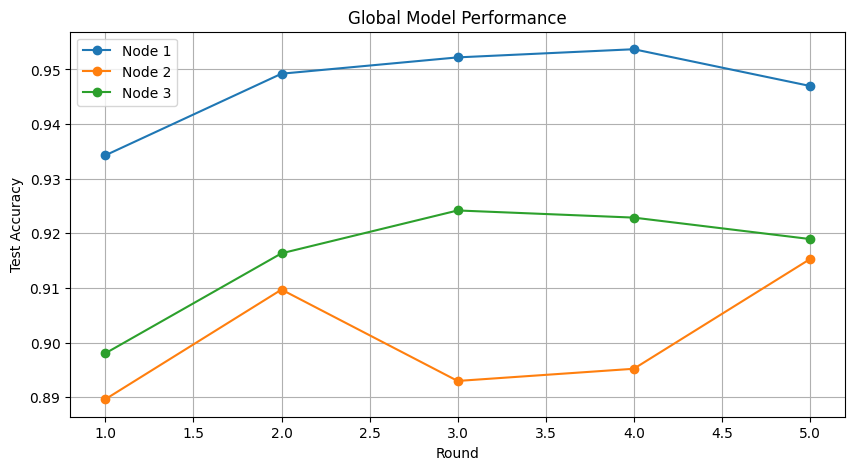

In [3]:
# Initial Setup and Imports
%cd /content
!rm -rf *  # Remove everything first
!git clone https://github.com/muhammmad-al/decentralized-ai-content-recommender.git
%cd decentralized-ai-content-recommender

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import logging
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = ' '.join(text.split())
    return text

def load_node_data(node_number):
    """Load node data with additional user interaction features"""
    # Load content datasets
    datasets = {
        'ai': pd.read_csv('data/raw/reddit_analysis_ai_5000_posts_with_sentiment.csv'),
        'music': pd.read_csv('data/raw/reddit_analysis_music_5000_posts_with_sentiment.csv'),
        'web3': pd.read_csv('data/raw/reddit_analysis_web3_5000_posts_with_sentiment.csv')
    }

    # Load synthetic user interactions
    user_interactions = pd.read_csv('data/mock/user_interactions.csv')

    for df in datasets.values():
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour_utc'] = df['timestamp'].dt.hour

    def assign_region(hour):
        if 2 <= hour < 10:
            return 'EU'
        elif 10 <= hour < 18:
            return 'NA'
        else:
            return 'ASIA'

    region_map = {1: 'NA', 2: 'EU', 3: 'ASIA'}
    target_region = region_map[node_number]

    balanced_dfs = []
    for category, df in datasets.items():
        df['region'] = df['hour_utc'].apply(assign_region)
        regional_df = df[df['region'] == target_region].copy()
        regional_df['category'] = category

        # Add interaction features
        category_interactions = user_interactions[user_interactions['category'] == category]
        interaction_features = category_interactions.groupby('content_id').agg({
            'interaction_strength': 'mean',
            'engagement_duration': 'mean',
            'interaction_type': lambda x: x.value_counts().index[0]
        }).reset_index()

        regional_df = pd.merge(
            regional_df,
            interaction_features,
            left_index=True,
            right_on='content_id',
            how='left'
        )

        regional_df['interaction_strength'] = regional_df['interaction_strength'].fillna(0)
        regional_df['engagement_duration'] = regional_df['engagement_duration'].fillna(0)
        regional_df['interaction_type'] = regional_df['interaction_type'].fillna('none')

        balanced_dfs.append(regional_df)

    df = pd.concat(balanced_dfs, ignore_index=True)

    # Feature engineering
    df['cleaned_title'] = df['title'].apply(preprocess_text)
    df['cleaned_content'] = df['cleaned_text'].apply(preprocess_text)
    df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_content']
    df['score_log'] = np.log1p(df['score'])
    df['comments_log'] = np.log1p(df['num_comments'])
    df['text_word_count'] = df['combined_text'].str.split().str.len()
    df['sentiment_compound'] = (df['textblob_sentiment'] + df['transformer_score']) / 2
    df['sentiment_magnitude'] = abs(df['textblob_sentiment'])

    numerical_cols = ['score_log', 'comments_log', 'text_word_count',
                     'sentiment_compound', 'sentiment_magnitude',
                     'interaction_strength', 'engagement_duration']

    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    print(f"Node {node_number} ({target_region}) Dataset Overview:")
    print(f"Total samples: {len(df)}")
    print("\nCategory distribution:")
    print(df['category'].value_counts())
    return df

class FederatedNode:
    def __init__(self, df, node_number):
        self.df = df
        self.node_number = node_number
        self.prepare_data()

    def prepare_data(self):
        self.vectorizer = TfidfVectorizer(
            max_features=300,
            stop_words='english',
            ngram_range=(1, 1),
            min_df=2,
            max_df=0.95
        )
        X_text = self.vectorizer.fit_transform(self.df['combined_text']).toarray()

        numerical_features = ['score_log', 'comments_log', 'text_word_count',
                            'sentiment_compound', 'sentiment_magnitude',
                            'interaction_strength', 'engagement_duration']
        X_numerical = self.df[numerical_features].fillna(0).values

        self.X = np.hstack([X_text, X_numerical])
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.df['category'])

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y,
            random_state=42+self.node_number
        )

        self.class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        self.class_weights = dict(enumerate(self.class_weights))

    def create_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu',
                                input_shape=(self.X_train.shape[1],),
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train_local(self, global_weights):
        model = self.create_model()
        model.set_weights(global_weights)

        history = model.fit(
            self.X_train,
            self.y_train,
            epochs=5,
            batch_size=32,
            validation_split=0.2,
            class_weight=self.class_weights,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=3,
                    restore_best_weights=True
                )
            ],
            verbose=1
        )

        return model.get_weights(), history.history

    def evaluate(self, weights):
        model = self.create_model()
        model.set_weights(weights)

        test_loss, test_accuracy = model.evaluate(self.X_test, self.y_test, verbose=0)
        y_pred = model.predict(self.X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return {
            'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'predictions': y_pred_classes,
            'true_labels': self.y_test
        }

class FederatedServer:
    def __init__(self, input_shape, num_rounds=5):
        self.num_rounds = num_rounds
        self.global_model = self.create_global_model(input_shape)
        self.metrics_history = []

    def create_global_model(self, input_shape):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu',
                                input_shape=input_shape,
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def fedavg(self, weights_list, node_sizes):
        total_size = sum(node_sizes)
        weighted_weights = []

        for weights, size in zip(weights_list, node_sizes):
            scaling = size / total_size
            weighted = [layer * scaling for layer in weights]
            weighted_weights.append(weighted)

        averaged_weights = []
        for layers in zip(*weighted_weights):
            averaged_weights.append(sum(layers))

        return averaged_weights

    def train(self, nodes):
        for round_num in range(self.num_rounds):
            print(f"\nFederated Round {round_num + 1}/{self.num_rounds}")
            print("=" * 50)

            global_weights = self.global_model.get_weights()

            weights_list = []
            node_sizes = []
            node_metrics = []

            for node in nodes:
                print(f"\nTraining Node {node.node_number}")
                weights, metrics = node.train_local(global_weights)
                weights_list.append(weights)
                node_sizes.append(len(node.X_train))
                node_metrics.append(metrics)

            new_weights = self.fedavg(weights_list, node_sizes)
            self.global_model.set_weights(new_weights)

            round_metrics = self.evaluate_global_model(nodes)
            self.metrics_history.append(round_metrics)

            self.plot_metrics(round_num + 1)

    def evaluate_global_model(self, nodes):
        metrics = []
        weights = self.global_model.get_weights()

        for node in nodes:
            results = node.evaluate(weights)
            metrics.append({
                'node': node.node_number,
                'accuracy': results['test_accuracy'],
                'loss': results['test_loss']
            })

            print(f"Node {node.node_number} Test Accuracy: {results['test_accuracy']:.4f}")

        return metrics

    def plot_metrics(self, current_round):
        plt.figure(figsize=(10, 5))

        for node_idx in range(3):
            accuracies = [round_metric[node_idx]['accuracy']
                         for round_metric in self.metrics_history]
            plt.plot(range(1, current_round + 1), accuracies,
                    marker='o', label=f'Node {node_idx + 1}')

        plt.title('Global Model Performance')
        plt.xlabel('Round')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

def run_federated_learning():
    nodes = []
    for node_num in [1, 2, 3]:
        df = load_node_data(node_num)
        nodes.append(FederatedNode(df, node_num))

    input_shape = (nodes[0].X_train.shape[1],)
    server = FederatedServer(input_shape, num_rounds=5)

    server.train(nodes)

    return server, nodes

if __name__ == "__main__":
    server, nodes = run_federated_learning()